In [2]:
import os
import time

import numpy as np
import scipy as sp
import bottleneck as bn

import math
import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [3]:
# randomize parameters 
N = 1000
M = 20

# smoothness of the sensitivity
std_dev = 0.02

# coupon's face value limits
bj_min = 0.6   
bj_max = 0.6 + (M-1) * 0.1

bj = np.linspace(bj_min, bj_max, M)

# sensitivity limits
pij_low_min = 0.0
pij_low_max = 0.8

pij_hig_min = 0.2
pij_hig_max = 0.99

In [4]:
def linear_fun(x, x1, y1, x2, y2):
    """
    linear function (x1, y1) and (x2, y2)
    """
    slope = (y2 - y1) / (x2 - x1)

    return slope * (x - x1) + y1

In [5]:
def log_fun(x, x1, y1, x2, y2):
    """
    logarithmic function (x1, y1) and (x2, y2)
    """
    a = (y2 - y1) / (math.log(x2) - math.log(x1))
    b = y1 - a * math.log(x1)

    return a * np.log(x) + b

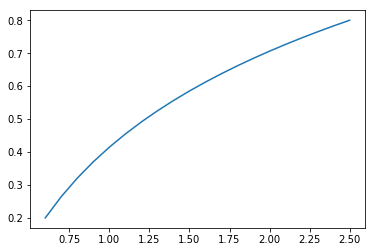

In [6]:
p = log_fun(bj, bj_min, 0.2, bj_max, 0.8)

plt.plot(bj, p)

In [7]:
def mono_fun(x, x1, y1, x2, y2):
    """
    construct a monotonoically increaseing function
    between (x1, y1) and (x2, y2)
    """
    funs = {
        "linear_fun": linear_fun,
        "log_fun": log_fun
    }

    rnd_name = random.choice(list(funs.keys()))
    rnd_fun = funs[rnd_name]

    return rnd_fun(x, x1, y1, x2, y2)

In [8]:
def noiser(x, n, std_dev):
    """
    Add the noise to the function.
    """
    return x + np.random.normal(0.0, std_dev, n)
    


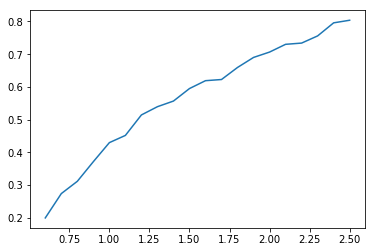

In [9]:
pij = mono_fun(bj, bj_min, 0.2, bj_max, 0.8)

pij = noiser(pij,M, 0.01)
plt.plot(bj, pij)
plt.show()

In [10]:
pij = []

std_dev = 0.02

for i in range(N):

    pij_low = np.random.uniform(pij_low_min, pij_low_max)
    a = max(pij_low,pij_hig_min)
    pij_hig = np.random.uniform(a, max(pij_hig_max,a))
    pij_one = mono_fun(bj, bj_min, pij_low, bj_max, pij_hig)
    pij_one = noiser(pij_one, M, std_dev)

    pij.append(pij_one)

pij = np.array(pij)


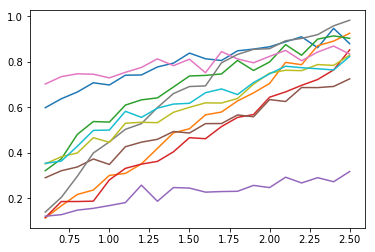

In [11]:
nplots = np.random.randint(0, N, 10)
for i in range(len(nplots)):
    plt.plot(bj, pij[nplots[i]])

plt.show()


In [12]:
def func(lamb, pij, sj, N):
    """Lagrangian function
    """
    varphi = pij - lamb
    # partition, Partition array so that the 
    # first 3 elements (indices 0, 1, 2) are the 
    # smallest 3 elements (note, as in this example, 
    # that the smallest 3 elements may not be sorted):
    varphi = -bn.partition(-varphi, 1, -1)[:, 0]
    return np.sum(varphi) * N * np.sum(lamb * sj)

In [13]:
aij = np.array([[3, 2, 1], [4, 5, 6], [8, 7, 9]])
lamb = np.array([1, 2, 3])

cij = aij - lamb

In [14]:
-bn.partition(-aij, 1, -1)[:, 0]

array([3, 6, 9])

In [15]:
bn.partition(aij, 2, -1)

array([[1, 2, 3],
       [4, 5, 6],
       [8, 7, 9]])

In [16]:
lamb0 = np.random.rand(M)

In [17]:
sj = np.random.rand(M)
sj = sj/np.sum(sj) + 0.01

In [18]:
func(lamb0, pij, sj, N)

351935.0769712641

In [19]:
varphi = pij - lamb0

In [20]:
bn.argpartition(-varphi, 1, -1)

array([[11, 13, 14, ..., 17, 18,  1],
       [ 9, 11, 13, ..., 17, 18,  1],
       [ 9, 13, 14, ...,  2,  0,  1],
       ...,
       [ 9, 11, 13, ..., 17, 18,  1],
       [11,  9, 13, ..., 17, 18,  1],
       [ 9, 11, 13, ..., 17, 18,  1]])

In [21]:
def dfunc(lamb, pij, sj, N):
    """derivative of Lagrangian
    """
    x = np.zeros((N, M))
    varphi = pij - lamb
    varphi_idx = bn.argpartition(-varphi, 1, -1)
    for i in range(N):
        for j in range(1):
            x[i, varphi_idx[i, j]] = 1
    return -np.sum(x, axis=0) + sj * N

In [22]:
dfunc(lamb0, pij, sj, N)

array([  31.46625943,   84.87099409,   64.22151172,   89.00592401,
         76.39077779,   20.73663369,   20.44221997,   86.59687426,
         84.700548  , -190.58561358,   50.08510579, -496.78902134,
         54.81077908,  -17.24172241,   80.91033243,   56.57993042,
         31.36893733,   42.96123728,   45.22833582,  -15.76004379])

In [23]:
def objective(pij, x):
    """Find the value of the objective function
    given the decision variables"""
    return np.sum(pij * x)

In [24]:
def objective_lamb(lamb, pij):
    """Find the value of the objective function
    given the Lagrangian multipiliers"""
    x = np.zeros((N, M))
    varphi = pij - lamb
    varphi_idx = bn.argpartition(-varphi, 1, -1)
    for i in range(N):
        for j in range(1):
            x[i, varphi_idx[i,j]] = 1
    return np.sum(pij * x)

In [25]:
# Check whether satisfies the constraints or not.
def checkConstraint(lamb, pij, sj, N):
    """check"""
    x = np.zeros((N, M))
    varphi = pij - lamb
    varphi_idx = bn.argpartition(-varphi, 1, -1)
    for i in range(N):
        for j in range(1):
            x[i, varphi_idx[i,j]] = 1
    return np.sum(x, axis = 0) - sj*N

In [26]:
def adam(theta0, pij, sj, N, verbose = True):
    """
    """
    if verbose:
        start = time.time()
    
    alpha, beta1, beta2, eps = 0.001, 0.9, 0.999, 1e-8
    beta1powert, beta2powert = 1.0, 1.0
    
    nitermax = 10000
    niter = 0
    
    theta_old = theta0 
    ndim = len(theta0)
    mold = np.zeros(ndim)
    vold = np.zeros(ndim)
    
    tolx = 1e-4
    tolf = 1e-4
    
    fold = func(theta0, pij, sj, N)
    
    while niter < nitermax:
        
        if niter % 100 == 0:
            print("iteration: {0}".format(niter))
        
        niter += 1
        
        g = dfunc(theta_old, pij, sj, N)
        mnew = beta1 * mold + (1-beta1)*g
        vnew = beta2 * vold + (1-beta2)*g*g
        
        beta1powert *= beta1
        beta2powert *= beta2
        
        mhat = mnew/(1 - beta1powert)
        vhat = vnew/(1 - beta2powert)
        
        theta_new = theta_old - alpha * mhat / (np.sqrt(vhat) + eps)
        
        if niter % 100 == 0:
            print("theta_old: {0}".format(theta_old))
            print("theta_new: {0}".format(theta_new))
        
        theta_new[theta_new < 0.0] = 0.0
        
        if np.sqrt(np.inner(theta_new - theta_old, theta_new - theta_old)) < tolx:

            if verbose:
                end = time.time()
                print("Running time: {}\n".format(end - start))
            return theta_new
        
        if niter%100 == 0:
            print("fold : {0}".format(fold))
        fnew = func(theta_new, pij, sj, N)
        if niter % 100 == 0:
            print("fnew : {0}".format(fnew))
        if np.abs(fold - fnew) < tolf:
            print("Here")
            if verbose:
                end = time.time()
                print("Running time: {}\n".format(end - start))
            return theta_new
        
        theta_old = theta_new
        fold = fnew
        mold = mnew
        vold = vnew
        
                
        if verbose and niter%100 == 0:
            print("{0}th iteration \t theta: {1} obj func: {2} \t grad: {3}"
                  .format(niter, theta_old, fold, g))
            
    print("EXCEED THE MAXIMUM ITERATION NUMBERS!")
    if verbose:
        end = time.time()
        print("Running time : {}\n".format(end - start))
        
    return theta_new

In [27]:
res = adam(lamb0, pij, sj, N, verbose = True)

iteration: 0
theta_old: [0.1210775  0.6779042  0.61745603 0.72582408 0.12020085 0.65823192
 0.77159693 0.82945005 0.5905016  0.14436873 0.86680728 0.15383704
 0.63618424 0.20896784 0.22758975 0.77521699 0.29935894 0.44641492
 0.43991418 0.37704179]
theta_new: [0.1214852  0.6769042  0.61645603 0.72482408 0.12039661 0.65723192
 0.77059693 0.82845005 0.5895016  0.1451006  0.86580728 0.15466831
 0.63518424 0.20974188 0.22837559 0.77421699 0.29863309 0.44541492
 0.43891418 0.37780661]
fold : 274863.87108310557
fnew : 274281.44537922763
100th iteration 	 theta: [0.1214852  0.6769042  0.61645603 0.72482408 0.12039661 0.65723192
 0.77059693 0.82845005 0.5895016  0.1451006  0.86580728 0.15466831
 0.63518424 0.20974188 0.22837559 0.77421699 0.29863309 0.44541492
 0.43891418 0.37780661] obj func: 274281.44537922763 	 grad: [  -4.53374057   84.87099409   64.22151172   89.00592401  -52.60922221
   20.73663369   20.44221997   86.59687426   84.700548    -97.58561358
   50.08510579 -306.78902134   54.

In [28]:
import mip

I = range(N)
V = range(M)

model = mip.Model()

x = [[model.add_var(var_type = mip.BINARY) for j in V] for i in I]

model.objective = mip.maximize(mip.xsum(pij[i][j] * x[i][j] for i in I for j in V))

# local constraints, only 3 benefits recommended for 
for i in I:
    model += mip.xsum(x[i][j] for j in V) == 1
    
# global constraints, the coupons are limited by numbers
for j in V:
    model += mip.xsum(x[i][j] for i in I) <= sj[j] * N

In [29]:
model.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [30]:
model.objective_value

677.4901537639965

In [31]:
objective_lamb(res, pij)

678.0070710494002

In [34]:
x[0][0].x

0.0

In [35]:
x[0][0]